In [11]:
#pip install -qq diffusers==0.31
#!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 64 kB 3.1 MB/s             


## 1. 윤곽선 검출

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

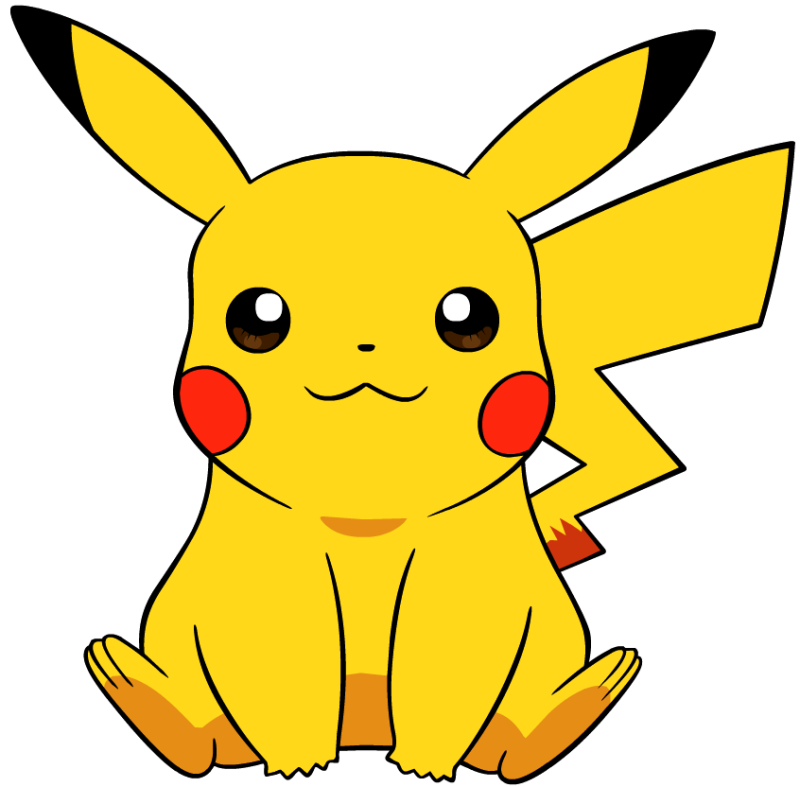

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://mblogthumb-phinf.pstatic.net/20160817_259/retspe_14714118890125sC2j_PNG/%C7%C7%C4%AB%C3%F2_%281%29.png?type=w800"
)

image

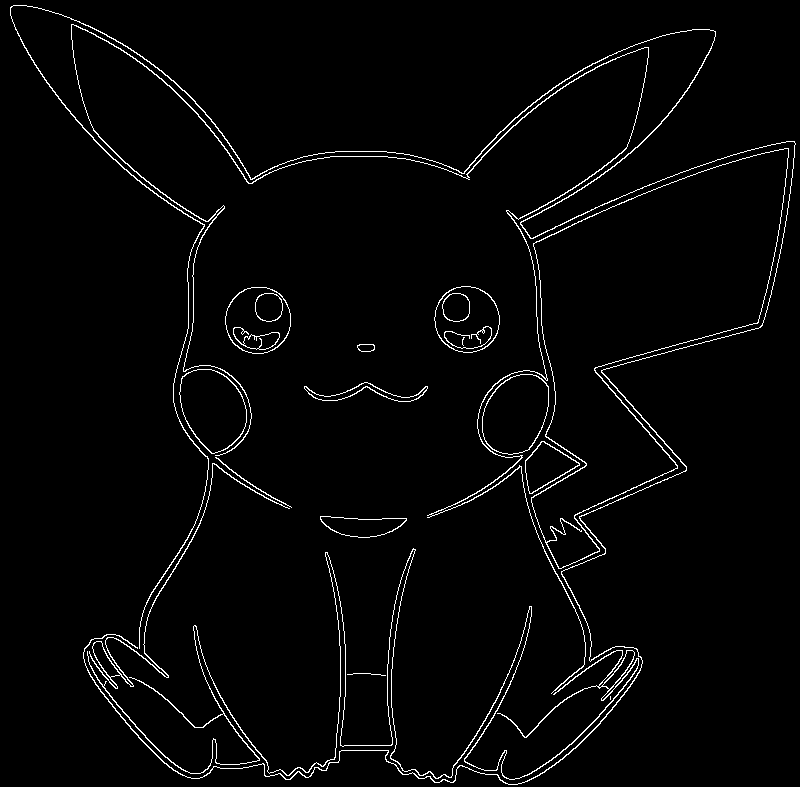

In [3]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [4]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


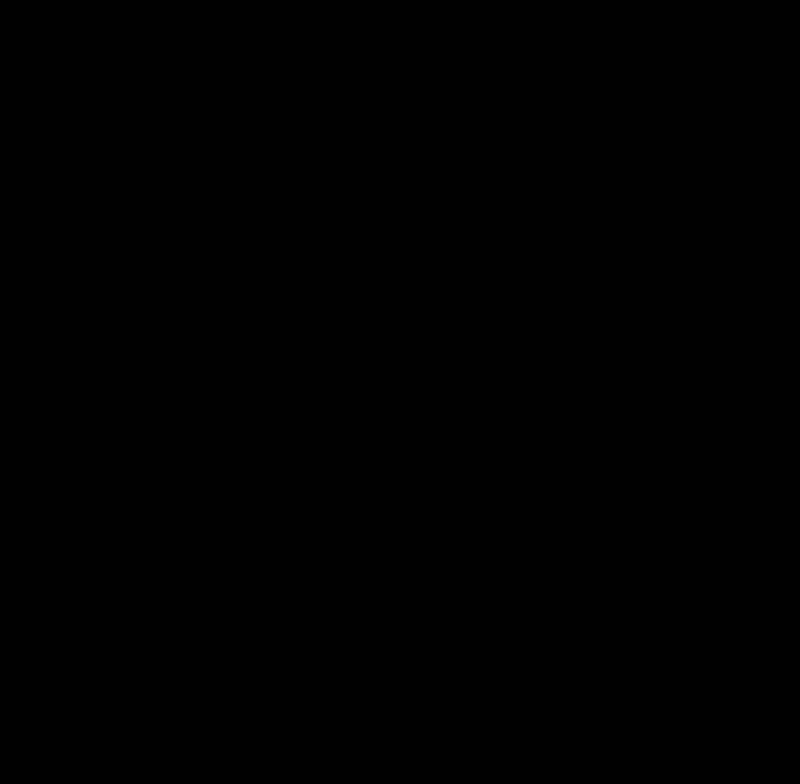

In [5]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image = canny_pipe(
    prompt="Pikachu giving a TED Talk about electricity to a crowd of lightbulbs, professional setting",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
canny_image.save("/aiffel/aiffel/diffusers/canny_pika.png")

# 생성된 이미지를 출력합니다.
canny_image

## 2. 포즈 검출

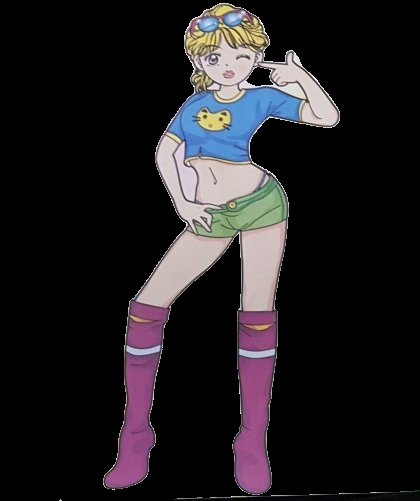

In [6]:
from diffusers.utils import load_image

openpose_image = load_image(
    "/aiffel/aiffel/diffusers/기분-removebg-preview.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


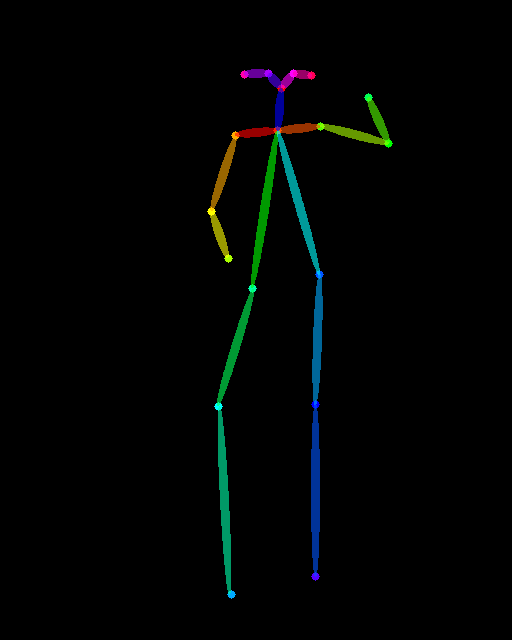

In [12]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [13]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

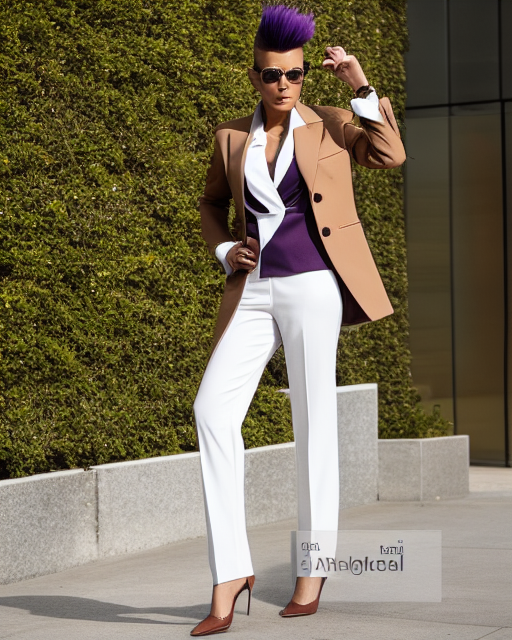

In [14]:
from diffusers import UniPCMultistepScheduler
import torch

# 스케줄러 교체 & 모델을 CUDA로 이동
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# ✅ 동일한 이미지를 생성하기 위해 seed를 고정
generator = torch.manual_seed(35)

# ✅ 프롬프트 설정
prompt = '''
realistic, blank eyes, wearing a suit in camel brown color with a shirt in white color,
short colored purple mohawk-style hair with exaggerated, angular spikes swept upward,
standing confidently with a smirk, 
striking a confident pose with one hand on her hip and the other pointing to her head.
She stands in a pinky background filled with soft heart shapes. 
'''
negative_prompt = "ugly, low quality, blurry, extra limbs, bad anatomy, distorted face"

# ✅ 이미지 생성
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=1.0,   # 보통 0.5 ~ 2.0 사이에서 조정
    num_inference_steps=20,
    generator=generator,
    image=openpose_image                # ← OpenPose 조건 이미지 입력
).images[0]

# ✅ 이미지 출력
openpose_image1

## 3. 윤곽선 + 포즈

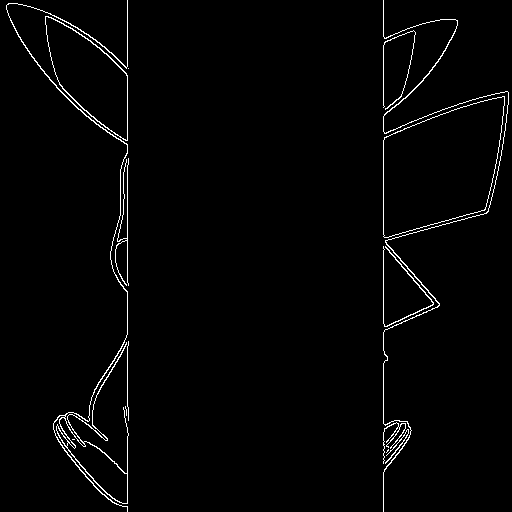

In [15]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np

# ✅ 이미지를 불러옵니다 (예: URL 또는 경로)
canny_image = load_image("https://mblogthumb-phinf.pstatic.net/20160817_259/retspe_14714118890125sC2j_PNG/%C7%C7%C4%AB%C3%F2_%281%29.png?type=w800")
canny_image = canny_image.resize((512, 512))  # 필요한 크기로 리사이즈

# ✅ threshold 값을 설정합니다
low_threshold = 100
high_threshold = 200

# ✅ 이미지를 NumPy 배열로 변환하고 GRAYSCALE로 변경
canny_image = np.array(canny_image.convert("L"))

# ✅ 가운데 영역을 지워줍니다 (조건 피처를 제거하는 용도)
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# ✅ Canny 엣지 검출
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)

# ✅ 다시 RGB로 변환
canny_image = np.stack([canny_image] * 3, axis=-1)

# ✅ NumPy 배열을 PIL 이미지로 변환
canny_image = Image.fromarray(canny_image)

# 결과 출력 (Colab이나 Jupyter에서는 바로 보여짐)
canny_image

cuda


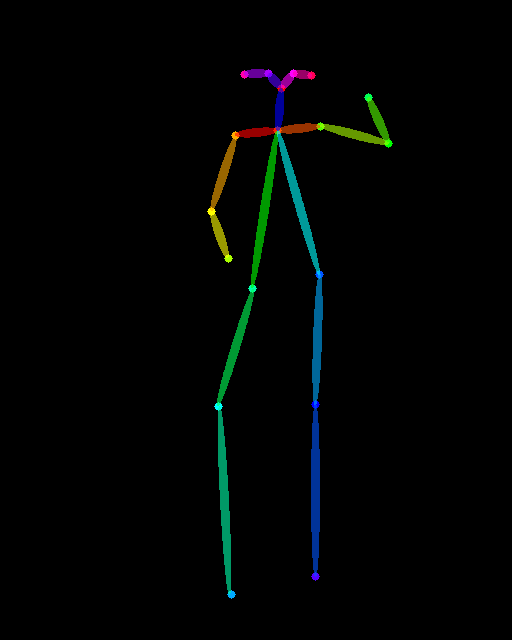

In [16]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# ✅ 이미지를 불러옵니다 (예: URL 또는 로컬 경로)
openpose_image = load_image("/aiffel/aiffel/diffusers/기분-removebg-preview.png")

# ✅ OpenPose Detector 초기화
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# ✅ 포즈 검출 (출력: PIL 이미지 형식의 pose map)
openpose_image = openpose(openpose_image)
openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

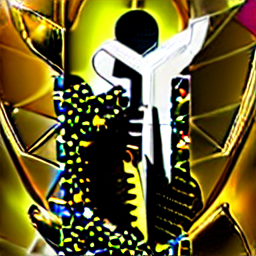

In [17]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# ✅ Edge Detection과 Openpose 두 개의 ControlNet 모델을 로드
controlnet_canny = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
controlnet_openpose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)

# ✅ 두 모델을 리스트로 묶음
controlnets = [controlnet_openpose, controlnet_canny]

# ✅ 멀티 ControlNet 파이프라인 생성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# ✅ 스케줄러 및 CUDA 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# ✅ 프롬프트 작성
prompt = '''
realistic, blank eyes, wearing a suit in camel brown color with a shirt in white color,
short colored purple mohawk-style hair with exaggerated, angular spikes swept upward,
standing confidently with a smirk, 
striking a confident pose with one hand on her hip and the other pointing to her head.
She stands in a pinky background filled with soft heart shapes. 
'''
negative_prompt = "blurry, distorted, low quality, extra limbs"

# ✅ seed 고정
generator = torch.manual_seed(0)

# ✅ ControlNet용 condition 이미지 순서대로 전달 (openpose, canny)
images = [openpose_image, canny_image]

# ✅ 이미지 생성
image = pipe(
    prompt=prompt,
    width=256,
    height=256,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 0.8]  # 각 controlnet의 영향력 조절
).images[0]

# ✅ 이미지 출력
image

## 4. 윤곽선+포즈 실험

- controlnets 순서 바꿔보기
- 각 controlnet의 영향력 동일하게 바꿔보기

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


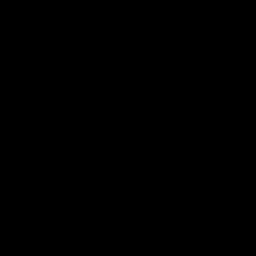

In [19]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

# ✅ 리스트의 순서 변경
controlnets = [controlnet_canny, controlnet_openpose]

# ✅ 멀티 ControlNet 파이프라인 생성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float16
)

# ✅ 스케줄러 및 CUDA 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# ✅ 프롬프트 작성
prompt = '''
realistic, blank eyes, wearing a suit in camel brown color with a shirt in white color,
short colored purple mohawk-style hair with exaggerated, angular spikes swept upward,
standing confidently with a smirk, 
striking a confident pose with one hand on her hip and the other pointing to her head.
She stands in a pinky background filled with soft heart shapes. 
'''
negative_prompt = "blurry, distorted, low quality, extra limbs"

# ✅ seed 고정
generator = torch.manual_seed(0)

# ✅ ControlNet용 condition 이미지 순서대로 전달 (openpose, canny)
images = [openpose_image, canny_image]

# ✅ 이미지 생성
image = pipe(
    prompt=prompt,
    width=256,
    height=256,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,  # ControlNet condition 입력
    controlnet_conditioning_scale=[1.0, 1.0]  # 각 controlnet의 영향력 동일하게 변경
).images[0]

# ✅ 이미지 출력
image

## 5. 회고

1.    
동일한 코드로 여러 버전의 이미지를 생성해보고 싶어서   
generator의 seed를 30번 정도? 변경해가며 돌려봤었는데   
이미 할당된 memory가 너무 많다며 더이상 이미지 생성이 되지 않는 이슈가 있었다.
cache 지우는 코드도 여러번 돌려보았으나 소용이 없었음...    
image, canny_image 등 이전에 선언했었던 변수들을 del 해도 소용없었음...   
무엇이 원인이었을지 잘 모르겠다.

2.   
controlnets 순서 바꾸고, 각 controlnet의 영향력 동일하게 바꿔보았는데   
생성된 이미지가 선정적일 수 있다며 그냥 검정색 이미지만 나왔음...   
이것도 왜 이런건지 모르겠다